In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

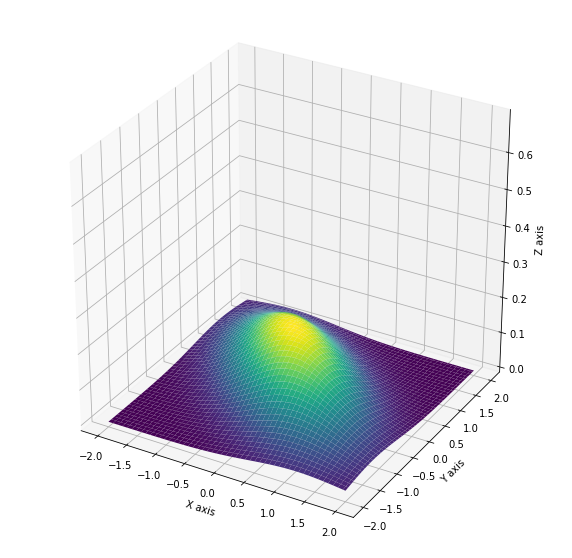

In [9]:
cov = np.array([[1, -0.6],
                [-0.6, 1]])
n = 100
x = np.linspace(-2, 2, n)
x, y = np.meshgrid(x, x)
pos = np.zeros([n, n, 2])
pos[:, :, 0] = x
pos[:, :, 1] = y

norm = stats.multivariate_normal(np.zeros(2), cov)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, norm.pdf(pos),cmap='viridis',linewidth=0)
ax.set_zlim(0, 0.7)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

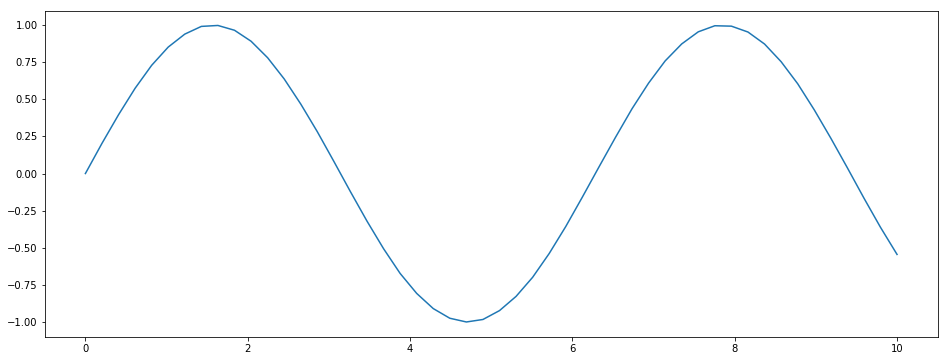

In [10]:
n = 50
x = np.linspace(0, 10, n)

# Define the gaussian with mu = sin(x) and negligible covariance matrix 
norm = stats.multivariate_normal(mean=np.sin(x), cov=np.eye(n) * 1e-6)
plt.figure(figsize=(16, 6))

# Taking a sample from the distribution and plotting it.
plt.plot(x, norm.rvs())

[[<matplotlib.lines.Line2D at 0x7fdac5e3b320>],

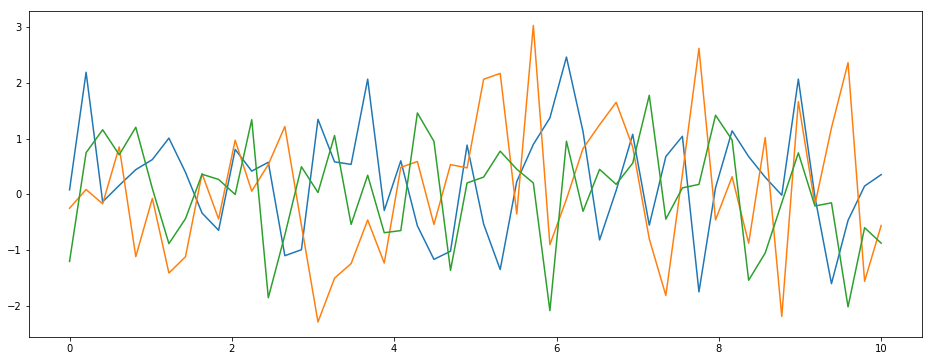

In [11]:
np.random.seed(18)

# Define the gaussian with mu = 0 and a covariance matrix w/o any correlation, 
# but w/ uncertainty
norm = stats.multivariate_normal(mean=np.zeros(n), cov=np.eye(n))
plt.figure(figsize=(16, 6))

# Taking 3 sample from the distribution and plotting it.
[plt.plot(x, norm.rvs()) for _ in range(3)]

[[<matplotlib.lines.Line2D at 0x7fdac411bef0>],

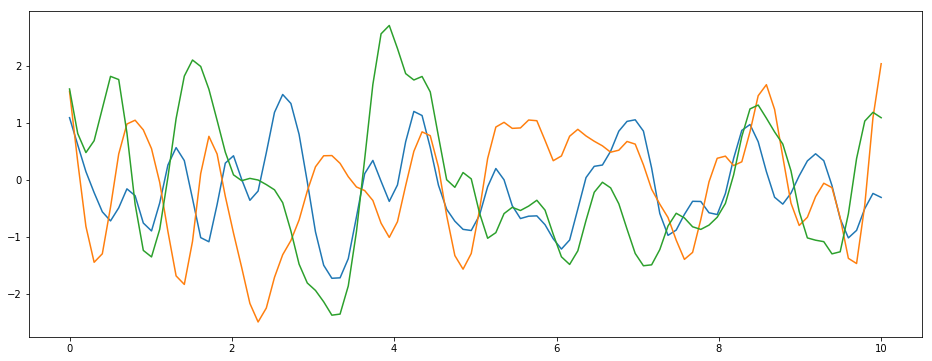

In [12]:
def kernel(m1, m2, l=0.8):
    return np.exp(- 1 / (2 * l**2) * (m1[:, None] - m2)**2)

n = 100
x = np.linspace(0, 10, n)
cov = kernel(x, x, 0.215)

norm = stats.multivariate_normal(mean=np.zeros(n), cov=cov)
plt.figure(figsize=(16, 6))
[plt.plot(x, norm.rvs()) for _ in range(3)]

In [13]:
%%latex
\begin{equation}
\begin{pmatrix}
f \\
f_*
\end{pmatrix}
= \mathcal{N} \begin{pmatrix}
\begin{bmatrix}
\mu \\
\mu_* \\  
\end{bmatrix},
\begin{bmatrix}
K & K_* \\
K_*^T & K_{**}
\end{bmatrix}
\end{pmatrix}
\end{equation}

<IPython.core.display.Latex object>

In [14]:
# squared exponential kernel.
# Gives more correleation to values of x close by.
# https://www.cs.toronto.edu/~duvenaud/cookbook/
def kernel(m1, m2, l=1):
    return np.exp(- 1 / (2 * l**2) * (m1[:, None] - m2)**2)

n = 50
x = np.linspace(0, 10, n)
cov = kernel(x, x, 0.44)
# Note that x_ij close by are strongly correlated and x_ij+n less
cov[:4, :4]

array([[1.        , 0.89801781, 0.65033901, 0.3798084 ],
       [0.89801781, 1.        , 0.89801781, 0.65033901],
       [0.65033901, 0.89801781, 1.        , 0.89801781],
       [0.3798084 , 0.65033901, 0.89801781, 1.        ]])

[[<matplotlib.lines.Line2D at 0x7fdac6e54390>],

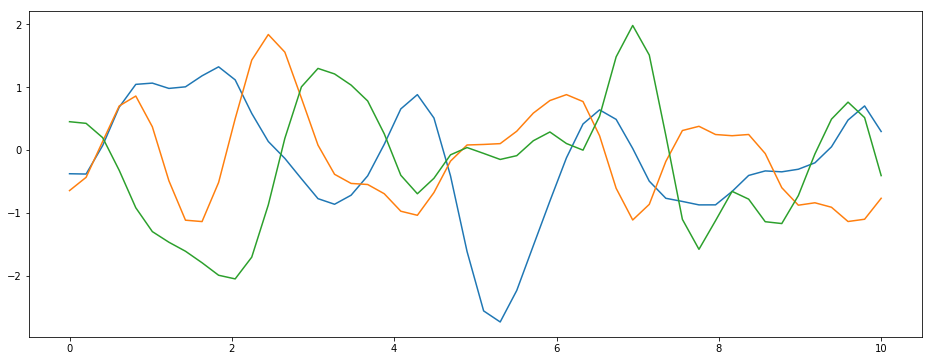

In [15]:
# We can plot a function defined by a gaussian. 
# The mean dictates the mean of you distribution of functions
# The covariance matrix determines the variance at a certain point x_i, but als determines how x_j and x_i are correlated.
norm = stats.multivariate_normal(mean=np.zeros(n), cov=cov)
plt.figure(figsize=(16, 6))
[plt.plot(x, norm.rvs()) for _ in range(3)]

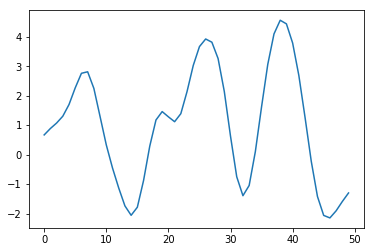

In [16]:
plt.plot(np.arange(50), cov @ np.random.normal(size=50))

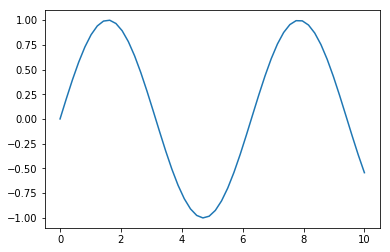

In [17]:
# We can also force the function to only show the mean by downscaling the covariance matrix
norm = stats.multivariate_normal(mean=np.sin(x), cov=cov * 1e-6).rvs()

plt.plot(x, norm)

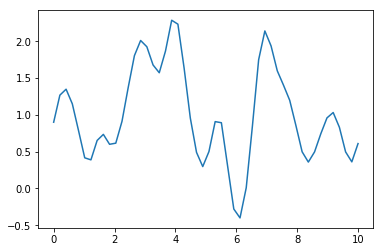

In [18]:
norm = stats.multivariate_normal(mean=np.ones(x.shape), cov=cov).rvs()

plt.plot(x, norm)

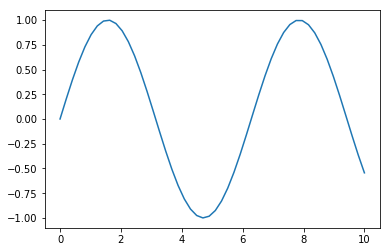

In [19]:
f = lambda x: np.sin(x)
x = np.linspace(0, 10)

plt.plot(x, f(x))

(0, 10)

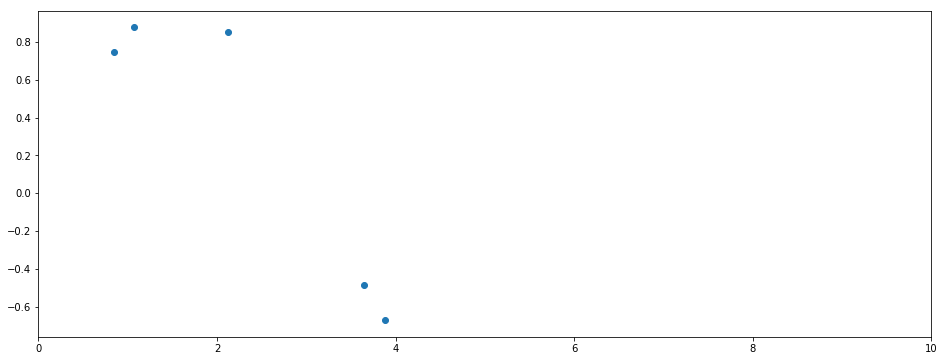

In [20]:
np.random.seed(512)
# True function
f = lambda x: np.sin(x)

# Known domain of true function f
x = np.random.uniform(0, 10, 5)

plt.figure(figsize=(16, 6))
plt.scatter(x, f(x))
plt.xlim(0, 10)

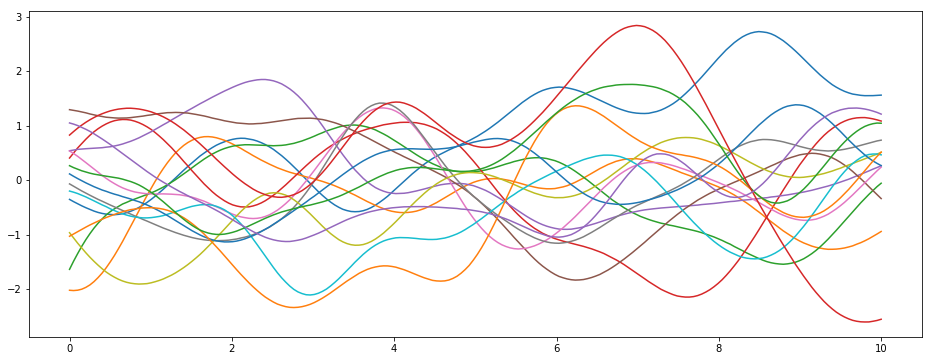

In [21]:
n = 200
# Domain of f* we want to infer 
x_s = np.linspace(0, 10, n)

# covariance matrix
K_ss = kernel(x_s, x_s, l=0.9)
 
# Is square root of matrix (standard deviation)
L_ss = np.linalg.cholesky(K_ss + 1e-6 * np.eye(n))

# N~(0, I) * L
f_prior = np.dot(L_ss, np.random.normal(size=(n, 15)))

plt.figure(figsize=(16, 6))
plt.plot(x_s, f_prior)

## Algorithm for GP

### Mean


$\text{L:= cholesky}(K + \sigma^2_n I)$

where $\sigma^2_n$ is the noise level (can be close to zero if no noise), $I$ is the identity matrix, $K$ is the covariance matrix, and cholesky can be seen as the square root of the matrix.

$\alpha$:= $L^{T^I} \cdot L^I y$

$f_*$ := $k_*^T \alpha$

### variance
v:=$L^I k_*$ 

The variance of the function $f_*$:

$\mathbb{V}[f_*]$:= $k_{**} - \text{v}^T\text{v}$

So the standard deviation is:

B:= $\text{cholesky}(\mathbb{V}[f_*])$

### posterior
$p(f|D) = \mu + \sigma[f_*]  \mathcal{N}(0, 1)$

In [22]:
# find mean mu*
K = kernel(x, x, l=0.9)
K_s = kernel(x, x_s, l=0.9)
L = np.linalg.cholesky(K + 1e-6 * np.eye(len(x)))
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f(x)))
mu = K_s.T @ alpha

In [23]:
v = np.linalg.solve(L, K_s)
variance = K_ss - v.T @ v

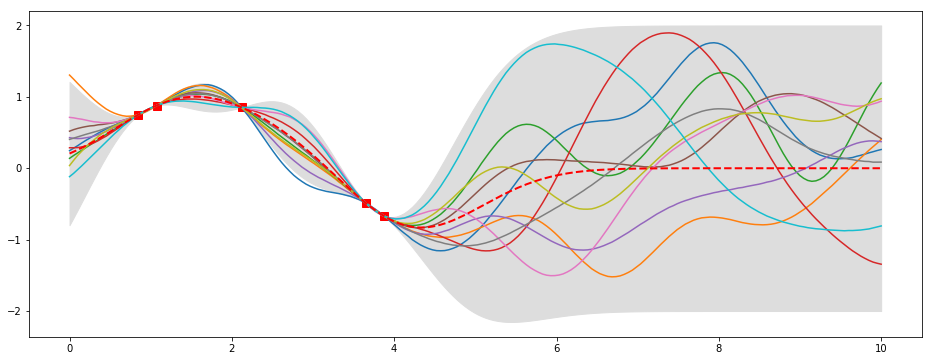

In [24]:
np.random.seed(18)

# Sample 10 functions from the posterior
B = np.linalg.cholesky(variance + 1e-6 * np.eye(variance.shape[0]))
f_post = mu[:, None] + B @ np.random.normal(size=(n, 10))

# Find standard deviation for plotting uncertainty values.
s2 = np.ones(n) - np.sum(v**2, axis=0)
std = np.sqrt(s2)

plt.figure(figsize=(16, 6))
plt.plot(x, f(x), 'bs', ms=8, color='red')
plt.plot(x_s, f_post)
plt.fill_between(x_s, mu - 2 * std, mu + 2 * std, color="#dddddd")
plt.plot(x_s, mu, 'r--', lw=2)
plt.show()

In [25]:
%%latex
\begin{equation}
p(x|y) = \mathcal{N}(\underbrace{\mu_x + \Sigma_{xy} \Sigma_y^{-1}(y - \mu_y)}_\textrm{conditional mean} ,  
                     \underbrace{\Sigma_x - \Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T}_\textrm{conditional covariance})
\end{equation}

<IPython.core.display.Latex object>

In [26]:
%%latex
\begin{equation}
p(x, y) = \mathcal{N} \begin{pmatrix}
\begin{bmatrix}
\mu_x \\
\mu_y \\  
\end{bmatrix},
\begin{bmatrix}
\Sigma_x & \Sigma_{xy} \\
\Sigma_{xy}^T & \Sigma_y
\end{bmatrix}
\end{pmatrix}
\end{equation}

<IPython.core.display.Latex object>

In [27]:
%%latex

\begin{equation}

\begin{pmatrix}
    f(x_1) \\
    f(x_2)  \\
    \vdots \\
    f(x_n)
\end{pmatrix} \sim \mathcal{N}

\begin{pmatrix}
    \begin{pmatrix}
        \mu_1 \\
        \mu_2  \\
        \vdots \\
        \mu_n
    \end{pmatrix},
    
    \begin{pmatrix}
        \sigma_{11} & \sigma_{12} & \cdots & \sigma_{1n} \\
        \sigma_{21} & \sigma_{22} & \cdots & \sigma_{2n}  \\
        \vdots      & \vdots        & \ddots \\
        \sigma_n    & \sigma_{n2} &        & \sigma_{nn}
    \end{pmatrix}
\end{pmatrix}

\end{equation}

<IPython.core.display.Latex object>